# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lunar_lander import LunarLanderEnv
from q_learning import QLearningAgent
from quantized_q_table import QuantizedQTable

from show_video import show_video
from video_maker import VideoMaker
import object_cache

In [3]:
# !pip uninstall box2d-py -y
# !pip install pygame==2.1.0
# !pip install box2d
# !pip install --upgrade gym
# !pip install gymnasium

# Env Exploration

In [4]:
env = LunarLanderEnv()

In [5]:
s = env.reset()
s

array([-3.5610198e-04,  1.4141150e+00, -3.6089193e-02,  1.4198896e-01,
        4.1947194e-04,  8.1747491e-03,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [6]:
env.getStateShape()

(8,)

In [7]:
env.getActionsCount()

np.int64(4)

In [8]:
smin, smax = env.getStatesMinMax()
print(np.array([smin, smax]).T)

[[-90.         90.       ]
 [-90.         90.       ]
 [ -5.          5.       ]
 [ -5.          5.       ]
 [ -3.1415927   3.1415927]
 [ -5.          5.       ]
 [ -0.          1.       ]
 [ -0.          1.       ]]


In [9]:
env.getStatesActionsNames()

(['state x_pos',
  'state y_pos',
  'state x_vel',
  'state y_vel',
  'state angle',
  'state angular_vel',
  'state left_leg_contact',
  'state right_leg_contact'],
 ['action no_op', 'action fire_left', 'action fire_main', 'action fire_right'])

# Random Walk

In [10]:
def randomWalk():
    frames = []
    s = env.reset()
    d = False
    
    while d == False:
        frames.append(env.render())
        a = np.random.randint(env.getActionsCount())
        s,d,r = env.step(a)
                
    frames.append(env.render())  
    return frames

In [11]:
for i in range(3):
    video = VideoMaker(f"random_walk_{i:2d}", fps=30)
    video.extend(randomWalk())
    video.export()
    show_video(video.path())

Moviepy - Building video video\random_walk_ 0.mp4.
Moviepy - Writing video video\random_walk_ 0.mp4



Moviepy - Done !
Moviepy - video ready video\random_walk_ 0.mp4


Moviepy - Building video video\random_walk_ 1.mp4.
Moviepy - Writing video video\random_walk_ 1.mp4



Moviepy - Done !
Moviepy - video ready video\random_walk_ 1.mp4


Moviepy - Building video video\random_walk_ 2.mp4.
Moviepy - Writing video video\random_walk_ 2.mp4



Moviepy - Done !
Moviepy - video ready video\random_walk_ 2.mp4


# Build Agent & Q Table

In [12]:
n_action = env.getActionsCount()
state_lenght = env.getStateShape()[0]
state_names, action_names = env.getStatesActionsNames()
state_min, state_max = env.getStatesMinMax()

In [13]:
q_table = QuantizedQTable(
    n_actions= n_action,
    action_names= action_names,
    state_names= state_names,
    states_min_vals= state_min,
    states_max_vals= state_max,
    n_quantization_lvls= 20,
    cache_folder= 'q_table_cache',
    use_access_counter= True,
)

Cache file exists, loading from it.


In [14]:
q_learning_agent = QLearningAgent(
    env= env,
    q_table= q_table,
    alpha= 0.05,
    discount_factor= 0.95,
    max_steps_per_episode= 1000,
)

# Test Env

In [15]:
history_list = object_cache.loadObject("history_list", lambda: [])

Object successfully loaded from cache\history_list.pickle


In [16]:
def try_greedy_policy(title, export=True, n_max_allowed_steps=1000):
    s = env.reset()
    d = False
    total_return = 0
    
    steps_counter = 0
    
    video = VideoMaker(title, fps=30)
        
    while not d and (steps_counter < n_max_allowed_steps):
        video.append(env.render())
        video.setText(f"{title}", color=(255,0,0),txt_position=(3,30))
        video.setText(f"Return: {total_return:+02.2f}, Steps: {steps_counter}", color=(255,0,0),txt_position=(3,60))
        
        a = q_learning_agent.act(s)
        s, d, r= env.step(a)
        
        total_return += r
        steps_counter+=1

    for i in range(5):
        video.append(env.render())
        video.setText(f"{title}", color=(255,0,0),txt_position=(3,30))
        video.setText(f"Return: {total_return:+02.2f}, Steps: {steps_counter}", color=(255,0,0),txt_position=(3,60))
        
    if export==True:
        show_video(video.export())
        
    return total_return, video

In [17]:
try_greedy_policy("try_before_training")

Moviepy - Building video video\try_before_training.mp4.
Moviepy - Writing video video\try_before_training.mp4



Moviepy - Done !
Moviepy - video ready video\try_before_training.mp4


(np.float64(192.45575834981793), <video_maker.VideoMaker at 0x1c311e87100>)

# Train

In [18]:
n_episodes = 40_000

In [19]:
def train_agent(n_episodes):

    for episode in range(len(history_list), n_episodes):

        epsilon = max(np.log10(1 - (episode / n_episodes)) + 0.9999, 0.05)

        G, s_counter = q_learning_agent.train_episode(epsilon)

        history_list.append([G, s_counter, epsilon])

        print(f"Episode {episode + 1:04d} / {n_episodes}, Epsilion: {epsilon:+0.3f}, Return = {G:+06.2f}, Steps = {s_counter:02d}")

        if (episode+1) % 500 == 0:
            try_greedy_policy(f"Agent after {episode+1} episodes")


    object_cache.saveObject(history_list, "history_list")
    q_table.save_to_cache()
    q_table.export2pandas()
        

In [20]:
train_agent(n_episodes)

Object successfully saved to cache\history_list.pickle


# History

In [21]:
plt.style.use(plt.style.available[12])

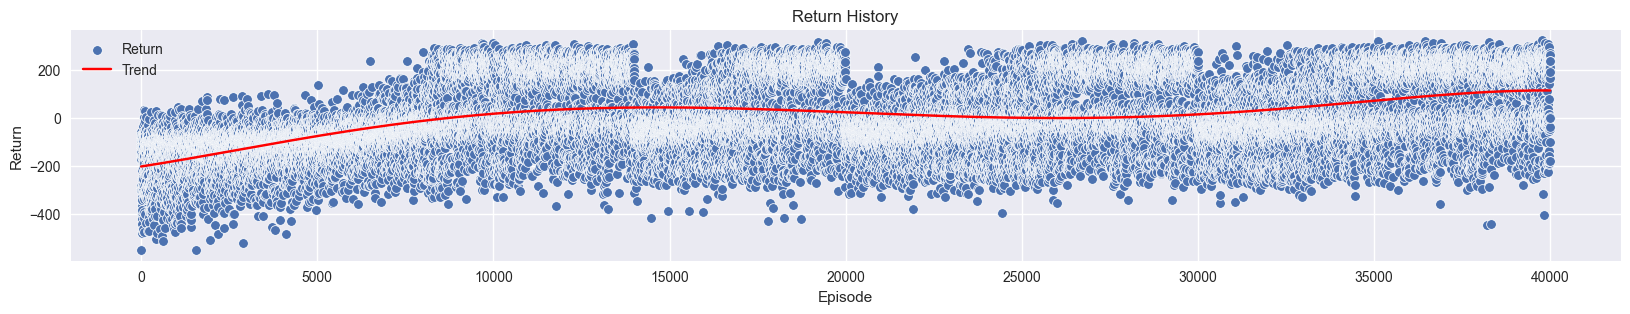

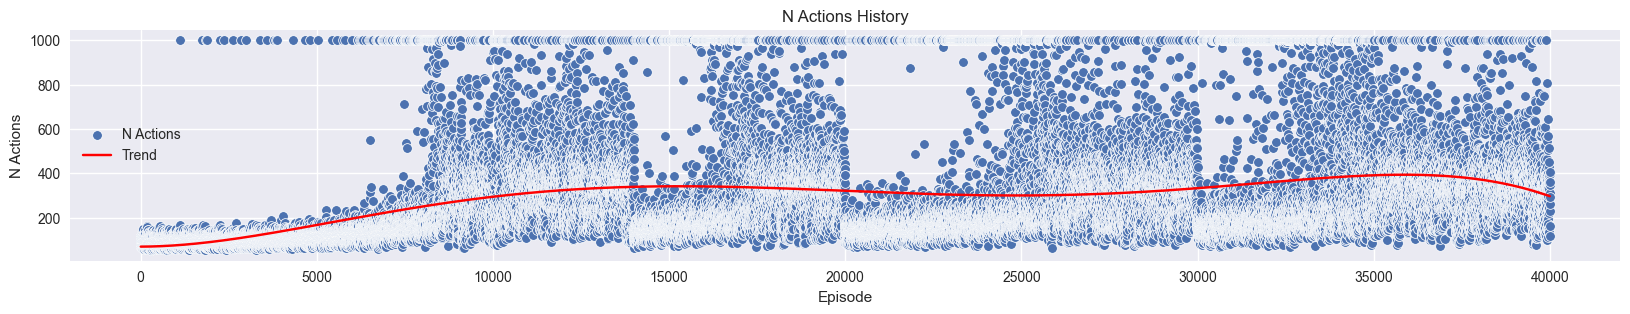

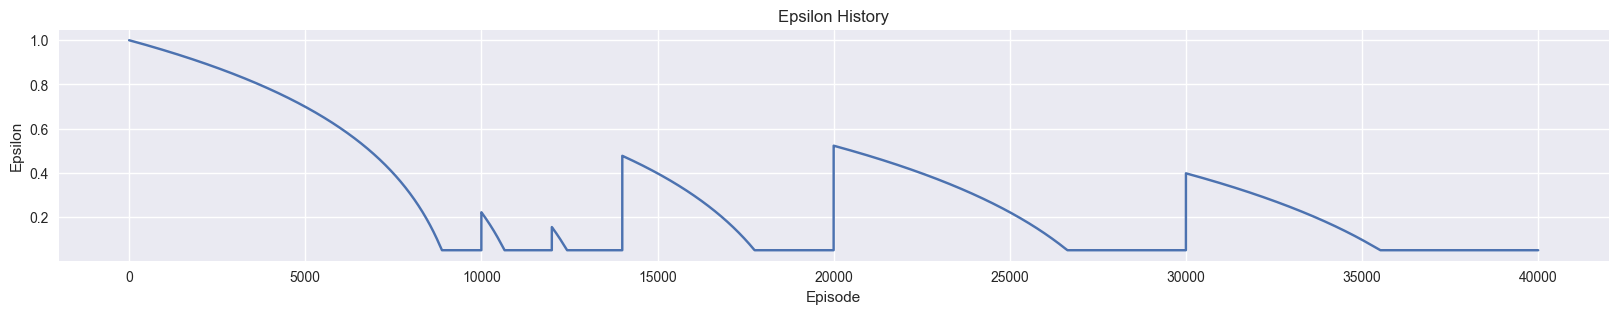

In [22]:
episodes = [i for i in range(len(history_list))]
returns = [x[0] for x in history_list]
n_actions = [x[1] for x in history_list]
epsilons = [x[2] for x in history_list]

# --- Return History with trend ---
plt.figure(figsize=(20,3))
plt.title("Return History")
sns.scatterplot(x=episodes, y=returns, label="Return")
sns.lineplot(x=episodes, y=np.poly1d(np.polyfit(episodes, returns, 5))(episodes), color='red', label="Trend")  # linear trend
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# --- N Actions History with trend ---
plt.figure(figsize=(20,3))
plt.title("N Actions History")
sns.scatterplot(x=episodes, y=n_actions, label="N Actions")
sns.lineplot(x=episodes, y=np.poly1d(np.polyfit(episodes, n_actions, 5))(episodes), color='red', label="Trend")  # linear trend
plt.xlabel("Episode")
plt.ylabel("N Actions")
plt.legend()
plt.show()

# --- Epsilon History (already a line, trend not really needed) ---
plt.figure(figsize=(20,3))
plt.title("Epsilon History")
sns.lineplot(x=episodes, y=epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()


# Test agent

In [24]:
for i in range(5):
    try_greedy_policy(f"Agent test no {i}")

Moviepy - Building video video\Agent test no 0.mp4.
Moviepy - Writing video video\Agent test no 0.mp4



Moviepy - Done !
Moviepy - video ready video\Agent test no 0.mp4


Moviepy - Building video video\Agent test no 1.mp4.
Moviepy - Writing video video\Agent test no 1.mp4



Moviepy - Done !
Moviepy - video ready video\Agent test no 1.mp4


Moviepy - Building video video\Agent test no 2.mp4.
Moviepy - Writing video video\Agent test no 2.mp4



Moviepy - Done !
Moviepy - video ready video\Agent test no 2.mp4


Moviepy - Building video video\Agent test no 3.mp4.
Moviepy - Writing video video\Agent test no 3.mp4



Moviepy - Done !
Moviepy - video ready video\Agent test no 3.mp4


Moviepy - Building video video\Agent test no 4.mp4.
Moviepy - Writing video video\Agent test no 4.mp4



Moviepy - Done !
Moviepy - video ready video\Agent test no 4.mp4
